In [328]:
import numpy as np
np.set_printoptions(precision=2,suppress=True)
import matplotlib.pyplot as plt
%matplotlib inline
from BLEanalysis.signals import Signals
from BLEanalysis.angleinference import Angles, getSample
sigs = Signals("noamploc2long.log",'d',angleOffset = 38)
angles = Angles(sigs.data) #inference class
sigs.summarise()

Transmitter       Number of records
        d                39557


In [329]:
#We'll test with this dataset!
testsigs = Signals("/home/mike/Documents/Research/bluetooth_experiments/March 26 2025 Field Trial/Range Trials/2.log",'c')

Text(0, 0.5, 'Count')

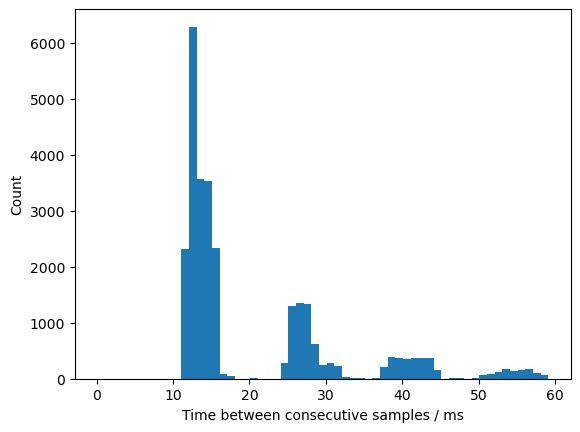

In [330]:
plt.hist(np.diff(sigs.data[:,3]),np.arange(0.1,60,1));
plt.xlabel('Time between consecutive samples / ms')
plt.ylabel('Count')
#counts = plt.hist(np.diff(sigs.data[:,3]),np.arange(0.1,100,11))[0][1:]
#counts[2:]/counts[1:-1]

In [331]:
intervals = np.array([-100,-50,0,50,100])

In [333]:
s = [] #sample lots of example times, see how many have data!
for i in range(1000):
    obs, obs_angles = getSample(sigs.data,747685+np.random.rand()*732482,intervals,raw=True,exclude_missing=10)        
    if np.all(np.isnan(obs)): continue #skip if ALL have no data
    s.append(np.mean(np.isnan(obs)))

In [337]:
print("%0.1f%% of packets missing (with inclusion criteria to be received with 10ms of target time)." % (100*np.mean(s)))

33.2% of packets missing (with inclusion criteria to be received with 10ms of target time).


In [360]:
#while True:
#    obs, obs_angles = getSample(testsigs.data,89e4+np.random.rand()*100000,intervals,raw=True)
#    if not np.any(np.isnan(obs)): break

accept_missing = 0 #set to 0 to have all packets included
#grab some example data, with no more than accept_missing received packets (must be within 10ms of target time).
while True:
    obs, obs_angles = getSample(testsigs.data,89e4+np.random.rand()*100000,intervals,raw=True,exclude_missing=10)
    if np.sum(np.isnan(obs))<=accept_missing: break

#need to infer the observed angles of the missing packets (from the angles sent in the other packets)
diff = np.median(((obs_angles-(np.pi*intervals/1000))%(2*np.pi))[~np.isnan(obs)])
obs_angles[np.isnan(obs)] = (np.pi*intervals/1000+diff)[np.isnan(obs)]        

In [361]:
obs,obs_angles

(array([-77., -75., -78., -85., -88.]), array([0.03, 0.19, 0.38, 0.54, 0.68]))

In [362]:
predangles = angles.infer(intervals,obs-obs[0],6) #using rejection sampling

In [363]:
#compute the averages
avgRSSIs,raw = sigs.averageRSSIsAtAngle('d',detrend=True,smooth=True,smoothwindow=np.deg2rad(2))

In [364]:
#this loops over all the angles...
#and for each, sums over lots of attenuations computing the probability of our observations for each (angle, attenuation), sums over these...
#to give p(y|angle) (proportional to p(angle|y)).
from scipy.stats import norm
missing_dist = norm(-93,4) 
angs = np.linspace(0,2*np.pi,180) #avgRSSIs[:,0]
log_p_y_given_Theta = []
log_p_kepty_given_Theta = []
for i,theta in enumerate(angs):
    print("%d/%d" % (i,len(angs)),end="\r")
    p = 0
    p_obkept = 0
    idxs = np.argmin(np.abs(avgRSSIs[:,0:1]-(((np.pi*intervals/1000)+theta)%(2*np.pi))),0)
    #plt.plot(avgRSSIs[idxs,1],'k-')
    unatt_pred = avgRSSIs[idxs,1]
    for a in np.linspace(0,50,100):        
        pred = unatt_pred-a
        p_kept = missing_dist.cdf(pred)*0.80 #* by a number as only seem to get 79% of packets even close to transmitter...
        p_obkept += np.prod((~np.isnan(obs)*p_kept)+(np.isnan(obs)*(1-p_kept)))
        p+=np.nanprod(norm(pred,3).pdf(obs)) 
    log_p_y_given_Theta.append(np.log(p))
    log_p_kepty_given_Theta.append(np.log(p_obkept))


In [365]:
#convert from log probs, to probs, and normalise.

p_y_given_Theta = np.exp(log_p_y_given_Theta-np.max(log_p_y_given_Theta))
p_y_given_Theta /= np.sum(p_y_given_Theta)

p_kepty_given_Theta = np.exp(log_p_kepty_given_Theta-np.max(log_p_kepty_given_Theta))
p_kepty_given_Theta /= np.sum(p_kepty_given_Theta)

p_given_Theta = p_y_given_Theta*p_kepty_given_Theta
p_given_Theta/=np.sum(p_given_Theta)

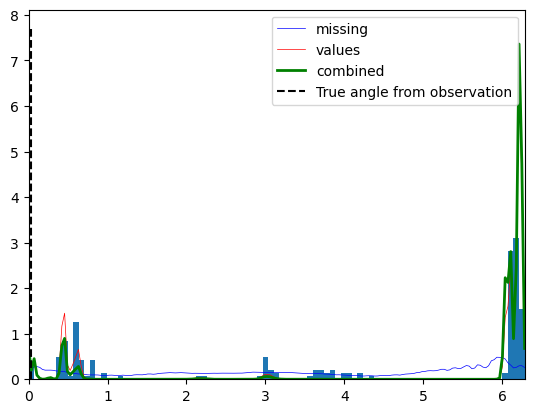

In [366]:
#plot the lot:

plt.plot(angs,len(p_kepty_given_Theta)*p_kepty_given_Theta/(2*np.pi),'b-',label='missing',alpha=1,lw=0.5) #division converts to density
plt.plot(angs,len(p_y_given_Theta)*p_y_given_Theta/(2*np.pi),'r-',label='values',alpha=1,lw=0.5) #division converts to density
plt.plot(angs,len(p_given_Theta)*p_given_Theta/(2*np.pi),'g-',label='combined',lw=2) #division converts to density
plt.hist(predangles,np.linspace(0,2*np.pi,90),density=True);
#plt.hist(np.r_[predangles-np.pi*2,predangles,predangles+np.pi*2],np.linspace(-np.pi,3*np.pi,))
plt.vlines(obs_angles[0],0,plt.gca().get_ylim()[-1],'k',linestyles='--',label='True angle from observation')
#plt.vlines(0,0,plt.gca().get_ylim()[-1],'k',linestyles='-',alpha=0.2)
#plt.vlines(np.pi*2,0,plt.gca().get_ylim()[-1],'k',linestyles='-',alpha=0.2)
plt.xlim([0,np.pi*2])
plt.legend()

In [285]:
obs,obs_angles

(array([-89., -86., -87., -88.,  nan]), array([3.8 , 4.01, 4.15, 4.31, 4.47]))

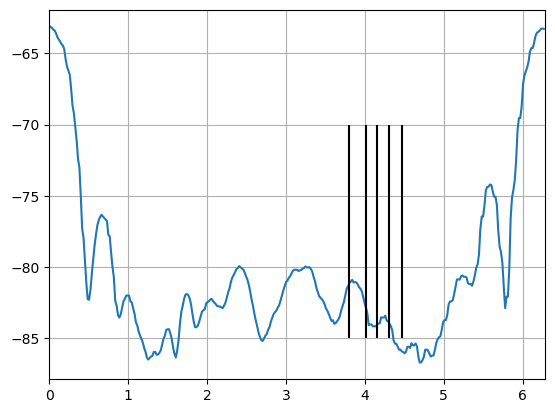

In [286]:
plt.plot(avgRSSIs[:,0],avgRSSIs[:,1])
plt.xlim([0,2*np.pi])
plt.grid()
plt.vlines(obs_angles,-85,-70,'k')

(array([3.6 , 3.75, 3.91, 4.07, 4.22]), array([3.82, 3.82, 3.96, 4.07, 4.21]))